<a href="https://colab.research.google.com/github/m3sibti/DL_projects/blob/master/Keras_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Guide

## Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## Understand the trainable weights

In [0]:
layer = keras.layers.Dense(6,)
layer.build(6)

In [0]:
# freeze the layer
layer.trainable = False

In [6]:
print(f'Weights -> {len(layer.weights)}')
print(f'Trainable -> {len(layer.trainable_weights)}')
print(f'Non-Trainable -> {len(layer.non_trainable_weights)}')

Weights -> 2
Trainable -> 0
Non-Trainable -> 2


## Keras Transfer Learning Workflow

Download a pre-trained model

In [7]:
model = keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(150, 150, 3)
)

83689472/83683744 [==============================] - 2s 0us/step


Freeze the model

In [0]:
model.trainable = False

Create a new model on top

In [0]:
inputs = keras.Input(shape=(150, 150, 3))

# pass the inputs throggh the base model in inference mode
x = model(inputs, training=False)

# create a new model on top of it
x = keras.layers.GlobalAveragePooling2D()(x)  # flatten the inputs

x = keras.layers.Dense(1)(x)
m_model = keras.Model(inputs, x)

Train the model on new data

In [13]:
x_train = tf.random.normal((5000, 150, 150, 3))
y_train = tf.random.uniform((5000, 1))

m_model.compile(
    loss='mse',
    optimizer='sgd',
)

m_model.fit(x_train, y_train, epochs=6)

Epoch 1/6
157/157 [==============================] - 6s 40ms/step - loss: 0.0842
Epoch 2/6
157/157 [==============================] - 6s 40ms/step - loss: 0.0841
Epoch 3/6
157/157 [==============================] - 6s 40ms/step - loss: 0.0840
Epoch 4/6
157/157 [==============================] - 6s 40ms/step - loss: 0.0840
Epoch 5/6
157/157 [==============================] - 6s 40ms/step - loss: 0.0839
Epoch 6/6
157/157 [==============================] - 6s 40ms/step - loss: 0.0839


See preds

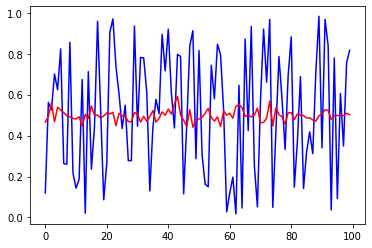

In [16]:
preds = m_model.predict(x_train)

plt.plot(y_train[:100], color='blue')
plt.plot(preds[:100], color='red')

Retrain the frozen model for some improvements, but try to keep the learning rate as low as possible because the model is too complex (has a lot of memory) but dataset is too little

In [18]:
model.trainable = True

# compiling the method change the trainable_weights states and compile new model for you
m_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(1e-6))

# fit on data 
m_model.fit(x_train, y_train, epochs=5)

Epoch 1/5
157/157 [==============================] - 30s 191ms/step - loss: 0.0838
Epoch 2/5
157/157 [==============================] - 30s 191ms/step - loss: 0.0831
Epoch 3/5
157/157 [==============================] - 30s 191ms/step - loss: 0.0827
Epoch 4/5
157/157 [==============================] - 30s 191ms/step - loss: 0.0823
Epoch 5/5
157/157 [==============================] - 30s 191ms/step - loss: 0.0819


Instead of `fit()` you can also use the custom training loop for trainable_weights 

A Custom Training loop

In [24]:
base_model = keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(150, 150, 3)
)

base_model.trainable = False

model = keras.Sequential([
                          keras.Input(shape=(150, 150, 3)),
                          keras.layers.GlobalAveragePooling2D(),
                          keras.layers.Dense(128,),
                          keras.layers.Dense(1,),
])

loss_fn = keras.losses.MeanSquaredError()
optim = keras.optimizers.Adam()

for i in range(1000):
  batch_start = i * 100
  batch_end = (i+1) * 100
  xi, yi = x_train[batch_start:batch_end], y_train[batch_start:batch_end]
  with tf.GradientTape() as tape:
    preds = model(xi)
    loss = loss_fn(yi, preds)

  grads = tape.gradient(loss, model.trainable_weights)
  optim.apply_gradients(zip(grads, model.trainable_weights))
  
  if i % 200 == 0:
    print(f'Loss = {loss}')


Loss = 0.3554055094718933
Loss = 0.0
Loss = 0.0
Loss = 0.0
Loss = 0.0


## End to End Example

### Getting the dataset

Here we will use cats vs dogs dataset from tensorflow_datasets if you have your own dataset use `tf.keras.preprocessing.image_dataset_from_directory` to load dataset from disk

In [0]:
import tensorflow_datasets as tfds

In [3]:
tfds.disable_progress_bar()

train, valid, test = tfds.load('cats_vs_dogs',
                               split=['train[:40%]','train[40%:50%]','train[50%:60%]'],
                               as_supervised=True)

print(f'Number of samples in train {tf.data.experimental.cardinality(train)}')
print(f'Number of samples in valid {tf.data.experimental.cardinality(valid)}')
print(f'Number of samples in test {tf.data.experimental.cardinality(test)}')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteU07CTP/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of samples in train 9305
Number of samples in valid 2326
Number of samples in test 2326


### Display the images in dataset

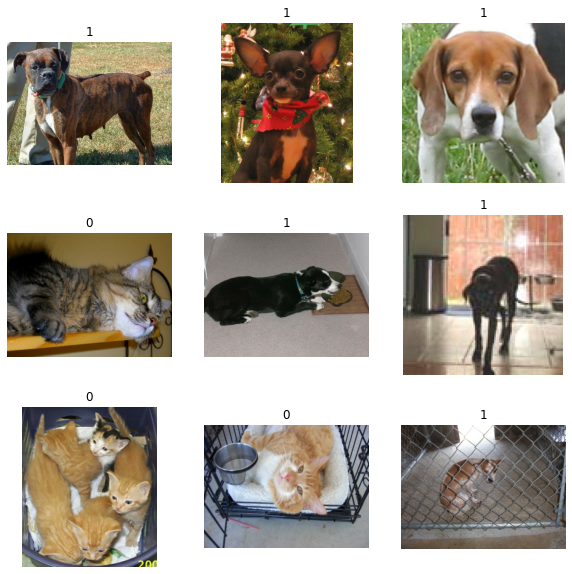

In [7]:
plt.figure(figsize=(10, 10))

for i, (img, label) in enumerate(train.take(9)):
  plt.subplot(3, 3, i+1)
  plt.imshow(img)
  plt.title(int(label))
  plt.axis('off')

### Pre-Process data

Its better to preprocess your data inside the model because when you deploy your model not every time you can preprocess the data, but here we do resizing and standardization before the model, it is also a concept to understand

#### Standarize data

In [0]:
size = (150, 150)

train = train.map(lambda x, y: (tf.image.resize(x, size), y))
valid = valid.map(lambda x, y: (tf.image.resize(x, size), y))
test = test.map(lambda x, y: (tf.image.resize(x, size), y))

#### Cache dataset with a batch_size

In [0]:
batch_size = 32

train = train.cache().batch(batch_size).prefetch(buffer_size=10)
valid = valid.cache().batch(batch_size).prefetch(buffer_size=10)
test = test.cache().batch(batch_size).prefetch(buffer_size=10)

#### Data Augmentation in Model

In [0]:
data_augmentation = keras.Sequential([
                                      keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
                                      keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

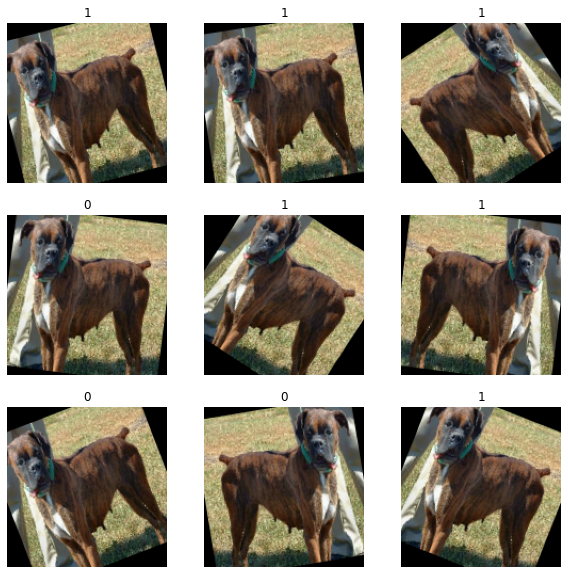

In [16]:
for img, label in train.take(1):
  plt.figure(figsize=(10, 10))
  m_img = img[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    aug_img = data_augmentation(tf.expand_dims(m_img, 0), training=True)
    plt.imshow(aug_img[0].numpy().astype('int32'))
    plt.title(int(label[i]))
    plt.axis('off')

### Train the model

Create a base model

In [0]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

base_model.trainable = False

Data Augmentation first

In [0]:
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)

Perform normalization

from `[0, 255]` to `[-1, 1]`

In [0]:
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5]*3)
var = mean ** 2
# set weights in norm layer
x = norm_layer(x)
norm_layer.set_weights([mean, var])

set base model `training = False` so, batchNorm layers always work in the inference mode

In [0]:
x = base_model(x, training=False)

In [0]:
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1,)(x)

model = keras.Model(inputs, outputs)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

### Train the top model

In [0]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [0]:
epochs = 10

In [32]:
model.fit(train, validation_data=valid, epochs=epochs)

Epoch 1/10
291/291 [==============================] - 27s 91ms/step - loss: 0.1921 - binary_accuracy: 0.9111 - val_loss: 0.1029 - val_binary_accuracy: 0.9635
Epoch 2/10
291/291 [==============================] - 23s 81ms/step - loss: 0.1382 - binary_accuracy: 0.9384 - val_loss: 0.0846 - val_binary_accuracy: 0.9682
Epoch 3/10
291/291 [==============================] - 23s 79ms/step - loss: 0.1339 - binary_accuracy: 0.9411 - val_loss: 0.0927 - val_binary_accuracy: 0.9673
Epoch 4/10
291/291 [==============================] - 23s 79ms/step - loss: 0.1323 - binary_accuracy: 0.9418 - val_loss: 0.0813 - val_binary_accuracy: 0.9716
Epoch 5/10
291/291 [==============================] - 23s 79ms/step - loss: 0.1153 - binary_accuracy: 0.9474 - val_loss: 0.0852 - val_binary_accuracy: 0.9682
Epoch 6/10
291/291 [==============================] - 23s 79ms/step - loss: 0.1217 - binary_accuracy: 0.9458 - val_loss: 0.0898 - val_binary_accuracy: 0.9665
Epoch 7/10
291/291 [==============================] 

### ReTrain the lower layers also

- using a lower learning rate

In [0]:
base_model.trainable = True

In [0]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-5),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [36]:
model.fit(train, validation_data = valid, epochs=5)

Epoch 1/5
291/291 [==============================] - 90s 309ms/step - loss: 0.0849 - binary_accuracy: 0.9650 - val_loss: 0.0511 - val_binary_accuracy: 0.9781
Epoch 2/5
291/291 [==============================] - 91s 313ms/step - loss: 0.0642 - binary_accuracy: 0.9759 - val_loss: 0.0458 - val_binary_accuracy: 0.9815
Epoch 3/5
291/291 [==============================] - 92s 317ms/step - loss: 0.0501 - binary_accuracy: 0.9805 - val_loss: 0.0433 - val_binary_accuracy: 0.9841
Epoch 4/5
291/291 [==============================] - 92s 317ms/step - loss: 0.0393 - binary_accuracy: 0.9851 - val_loss: 0.0476 - val_binary_accuracy: 0.9819
Epoch 5/5
291/291 [==============================] - 87s 300ms/step - loss: 0.0345 - binary_accuracy: 0.9869 - val_loss: 0.0473 - val_binary_accuracy: 0.9824


### Evaluate your model

In [37]:
loss, acc = model.evaluate(test)

73/73 [==============================] - 4s 61ms/step - loss: 0.0758 - binary_accuracy: 0.9772
